# Table of Contents

1. [Introduction and Objectives](#1-introduction-and-objectives)  
   - [1.1 Objective](#11-objective)

2. [Loading Configuration and Dataset](#2-loading-configuration-and-dataset)

3. [Exploratory Data Analysis](#3-exploratory-data-analysis)  
   - [3.1 Data Overview](#31-data-overview)  
   - [3.2 Checking for Missing Values](#32-checking-for-missing-values)  
   - [3.3 Checking for Duplicates](#33-checking-for-duplicates)  
   - [3.4 Analysis and Distribution of Ratings](#34-analysis-and-distribution-of-ratings)  
   - [3.5 Correlation Between Number of Ratings and Average Rating](#35-correlation-between-number-of-ratings-and-average-rating)  
   - [3.6 Distribution of Average Ratings per User](#36-distribution-of-average-ratings-per-user)  
   - [3.7 Analysis of Products with the Most Variety in Ratings](#37-analysis-of-products-with-the-most-variety-in-ratings)  
   - [3.8 Analysis of Popular vs. Less Popular Products](#38-analysis-of-popular-vs-less-popular-products)

4. [Collaborative Filtering with Surprise](#4-collaborative-filtering-with-surprise)  
   - [4.1 Data Preprocessing](#41-data-preprocessing)  
   - [4.2 Singular Value Decomposition (SVD)](#42-singular-value-decomposition-svd)  
   - [4.3 Non-Negative Matrix Factorization (NMF)](#43-non-negative-matrix-factorization-nmf)  
   - [4.4 BaselineOnly](#44-baselineonly)  
   - [4.5 CoClustering](#45-coclustering)  
   - [4.6 K-Nearest Neighbors](#46-k-nearest-neighbors)

5. [Model Performance Evaluation](#5-model-performance-evaluation)


# 1. Introduction and Objectives

In this project, we developed a recommendation system for an e-commerce platform using the Amazon Product Review Dataset. The goal was to recommend products to users based on their purchase and browsing history to enhance user engagement and increase sales.
We used the following technologies:

- **PostgreSQL** for data storage and SQL-based data manipulation.
- **Surprise** Library to build and evaluate collaborative filtering models, including SVD, KNN, and NMF.

This project focused on building and fine-tuning recommendation models, as well as evaluating their performance using metrics like RMSE and MAE.

# 2. Loading Configuration and Dataset

In this section, we will load the necessary libraries and the dataset. 


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [25]:
from sqlalchemy import create_engine

# Create an engine SQLAlchemy to connect to the database
DATABASE_TYPE = 'postgresql'
DBAPI = 'psycopg2'
ENDPOINT = 'localhost'  
USER = 'postgres'
PORT = 5432
DATABASE = 'amazon_reviews'

engine = create_engine(f"{DATABASE_TYPE}+{DBAPI}://{USER}@{ENDPOINT}:{PORT}/{DATABASE}")



In [26]:
# Import the data from the database
query = "SELECT * FROM reviews;"
df = pd.read_sql(query, engine)

# Afficher les premières lignes
df.head()

,userid,productid,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [27]:
- 

(100000, 4)

# 3. Exploratory Data Analysis

### 3.1. Data Overview

In [28]:
df.dtypes

userid        object
productid     object
rating       float64
timestamp      int64
dtype: object

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userid     100000 non-null  object 
 1   productid  100000 non-null  object 
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [30]:
df.describe()['rating'].T


count    100000.000000
mean          4.033080
std           1.355014
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [31]:
# Number of unique users and items
num_users = df['userid'].nunique()
num_items = df['productid'].nunique()
print(f"Nombre d'utilisateurs uniques: {num_users}")
print(f"Nombre de produits uniques: {num_items}")

Nombre d'utilisateurs uniques: 89938
Nombre de produits uniques: 6919


In [32]:
# Check how many ratings each user has given
user_counts = df['userid'].value_counts()
user_counts.describe()

count    89938.000000
mean         1.111877
std          0.740622
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        103.000000
Name: count, dtype: float64

### 3.2 Checking for Missing Values

In [33]:
# Check for missing values
df.isnull().sum()

userid       0
productid    0
rating       0
timestamp    0
dtype: int64

### 3.3 Checking for duplicates values

In [34]:
# Check for duplicate rows in the dataset
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Remove duplicates if necessary
df = df.drop_duplicates()
print("Duplicates removed.")


Number of duplicate rows: 0
Duplicates removed.


### 3.4 Analyse and Distribution of Ratings 

Implementation of a scraper to get the title of the products with the ASIN code (productid).

In [35]:
import requests
from bs4 import BeautifulSoup

def get_amazon_product_title(product_id):
    url = f"https://www.amazon.com/dp/{product_id}/"
    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15",
    "Accept-Language": "en-US,en;q=0.8,fr;q=0.6",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-User": "?1",
    "Sec-Fetch-Site": "none",
    "Sec-Fetch-Dest": "document"
}
    
    # Send an HTTP request to get the product page
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Failed to retrieve product {product_id}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the product title in the page
    product_title_tag = soup.find('span', {'id': 'productTitle'})
    if product_title_tag:
        return product_title_tag.get_text().strip()
    else:
        print(f"Product title not found for {product_id}")
        return None
    
test = get_amazon_product_title("0439886341")
print(test if test else "Product not found")

Digital Organizer and Messenger


We calculate the product counts and print the top 10 products with the highest number of reviews.

In [36]:
# Count the number of ratings per product
product_counts = df['productid'].value_counts()

# Summary statistics for ratings per product
print(product_counts.describe())

count    6919.000000
mean       14.452956
std        68.437520
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max      2547.000000
Name: count, dtype: float64


On average, a product has 16.4 reviews. The product with the most reviews has 18244 reviews. And 50% of the products have 2 or fewer reviews. So the mean is higher than the median, which indicates that the distribution is right-skewed.

/var/folders/0p/3yt8z7dd7j12_znn33d3fbc00000gn/T/ipykernel_72286/2427653599.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_titles, y=top_products.values, palette='viridis')


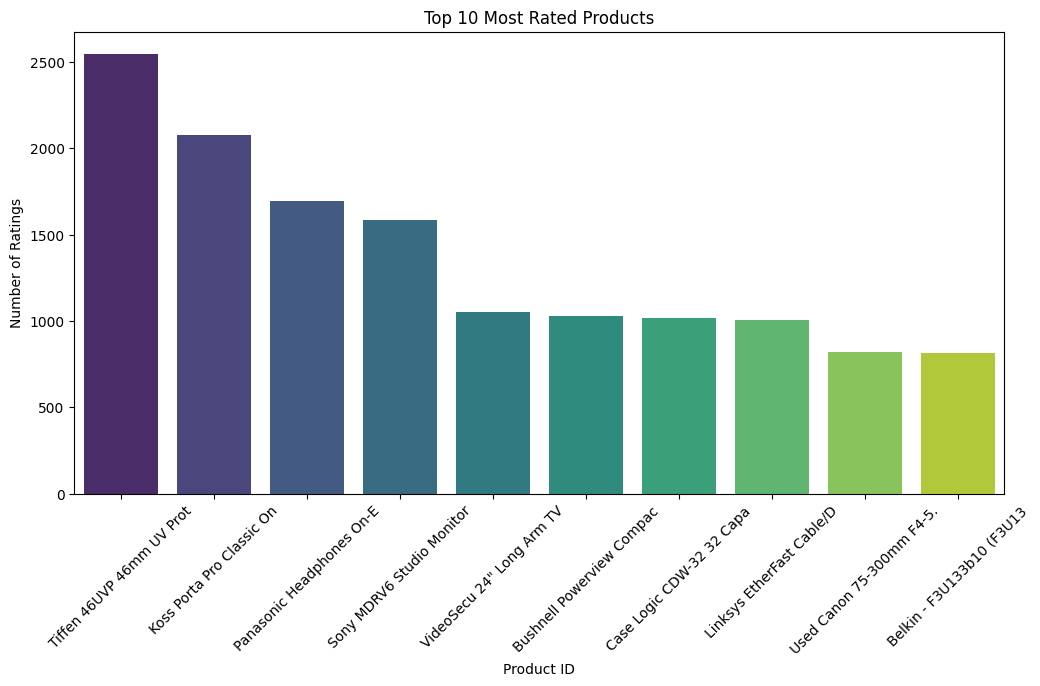

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 10
top_products = product_counts.head(top_n)

# Scrape the titles for the top N products
product_titles = []
for product_id in top_products.index:
    title = get_amazon_product_title(product_id)
    if title:
        # Limit title to the first 25 characters
        product_titles.append(title[:25])
    else:
        product_titles.append(f"Product {product_id}") 


# Add unknown titles with titles found in internet
product_title_mapping = {
    "B00DR0PDNE": "Google Chromecast HDMI",
    "B0074BW614": "Kindle Fire HD 7",
    "B003ES5ZUU": "AmazonBasics High-Speed",
    "B00622AG6S": "Venus Visage Blackhead",
    "B0002L5R78": "DVI Gear HDMI-2M 6 Feet",
}

# Apply mapping to the top products
for i, product_id in enumerate(top_products.index):
    if product_id in product_title_mapping:
        product_titles[i] = product_title_mapping[product_id]

plt.figure(figsize=(12,6))
sns.barplot(x=product_titles, y=top_products.values, palette='viridis')
plt.title(f"Top {top_n} Most Rated Products")
plt.xlabel("Product ID")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.show()


We can see that the product with the most reviews is the "Kindle Wireless Reading Device". We can also notice that their are 3 Kindle products in this top 10. So, it seems that Kindle products are very popular on Amazon.

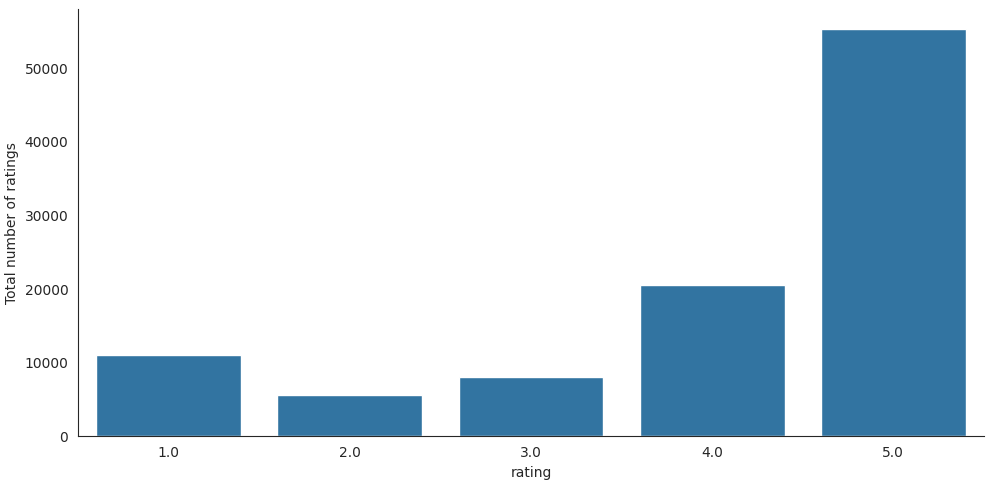

In [38]:
import seaborn as sns

with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=df, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

The distribution is right-skewed, with most ratings being 5. 

### 3.5 Correlation Between Number of Ratings and Average Rating


Correlation between the number of ratings and the average rating per user: 0.02


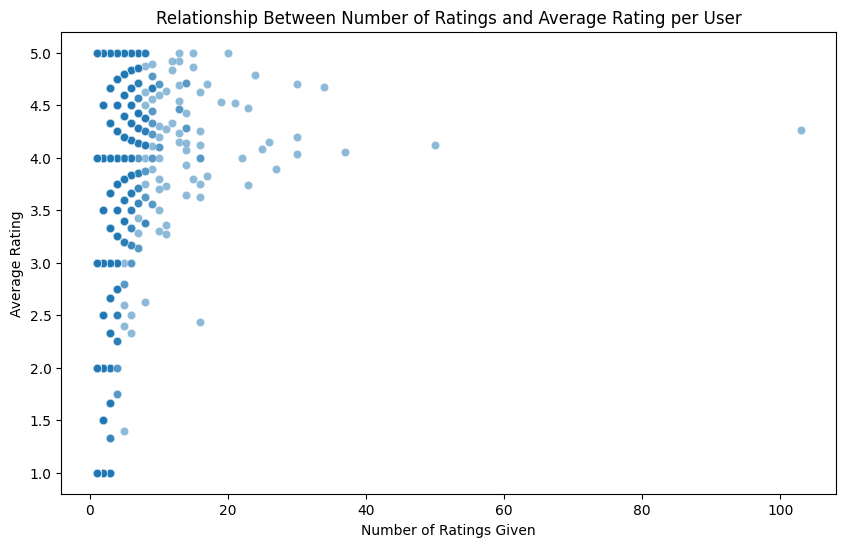

In [39]:
# Correlation between the number of ratings per user and their average rating
user_stats = df.groupby('userid')['rating'].agg(['count', 'mean']).reset_index()
correlation = user_stats['count'].corr(user_stats['mean'])
print(f"Correlation between the number of ratings and the average rating per user: {correlation:.2f}")

# Visualization of the correlation
plt.figure(figsize=(10,6))
sns.scatterplot(x='count', y='mean', data=user_stats, alpha=0.5)
plt.title("Relationship Between Number of Ratings and Average Rating per User")
plt.xlabel("Number of Ratings Given")
plt.ylabel("Average Rating")
plt.show()

### Distribution of Average Ratings per User

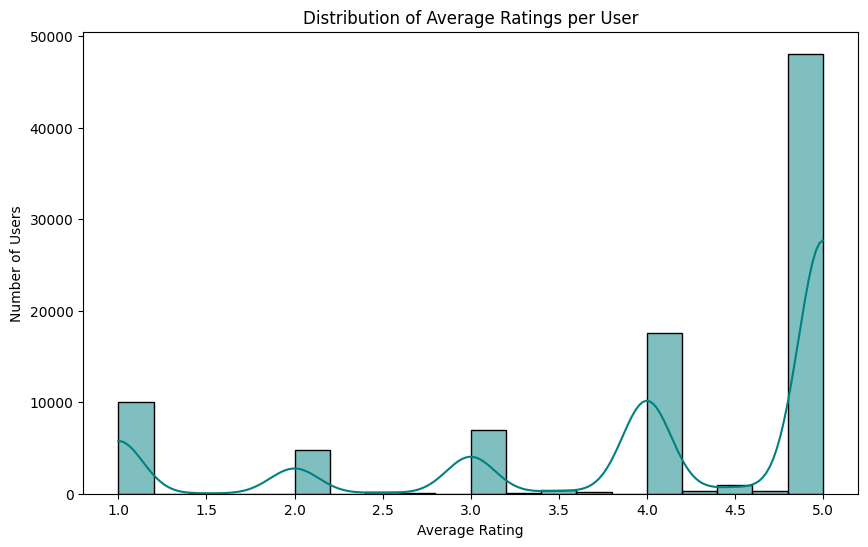

In [40]:
user_mean_ratings = df.groupby('userid')['rating'].mean()

# Visualization of the distribution of average ratings per user
plt.figure(figsize=(10,6))
sns.histplot(user_mean_ratings, bins=20, kde=True, color='teal')
plt.title("Distribution of Average Ratings per User")
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.show()

### 3.7 Analysis of Products with the Most Variety in Ratings


In [41]:
import requests
from bs4 import BeautifulSoup

# Function to get the product title from Amazon
def get_amazon_product_title(product_id):
    url = f"https://www.amazon.com/dp/{product_id}/"
    headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15",
    "Accept-Language": "en-US,en;q=0.8,fr;q=0.6",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-User": "?1",
    "Sec-Fetch-Site": "none",
    "Sec-Fetch-Dest": "document"
}
    
    # Send an HTTP request to get the product page
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Failed to retrieve product {product_id}")
        return None
    
    # Parse the content of the page with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the product title in the page
    product_title_tag = soup.find('span', {'id': 'productTitle'})
    if product_title_tag:
        return product_title_tag.get_text().strip()
    else:
        print(f"Product title not found for {product_id}")
        return None
    
test = get_amazon_product_title("0439886341")
print(test if test else "Product not found")

Digital Organizer and Messenger


Failed to retrieve product B00004Z9L2
Failed to retrieve product 998499659X


/var/folders/0p/3yt8z7dd7j12_znn33d3fbc00000gn/T/ipykernel_72286/3243437644.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_titles, y=top_variance_products.values, palette='coolwarm')


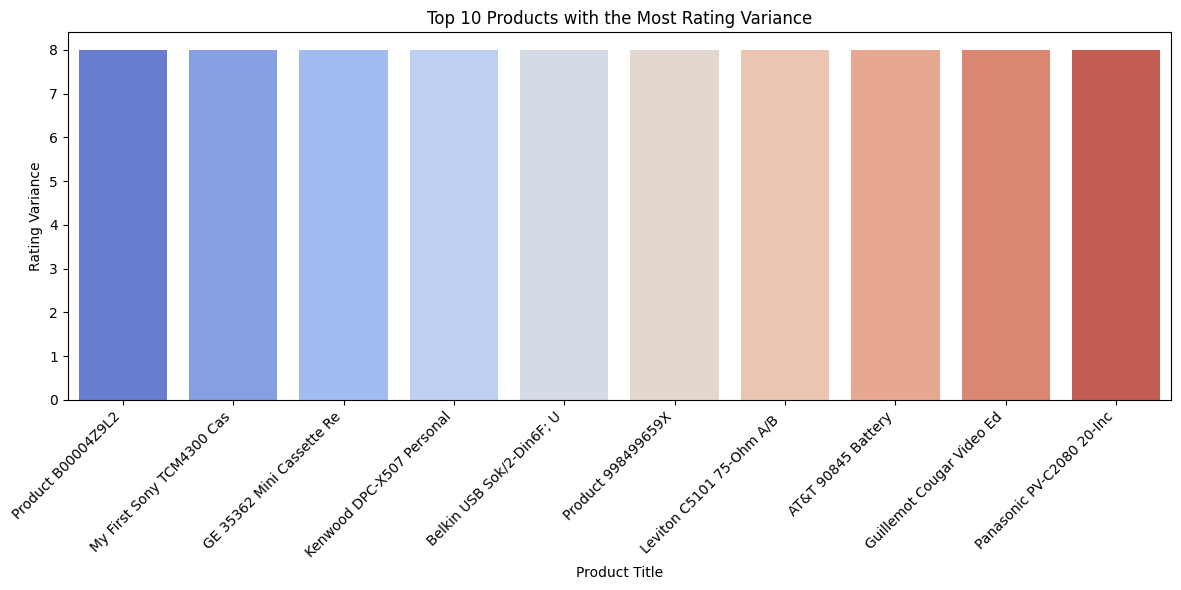

In [42]:
import matplotlib.pyplot as plt

# Variability in ratings for each product (variance)
product_variance = df.groupby('productid')['rating'].var().sort_values(ascending=False)

top_n = 10 

# Top 10 products with the most rating variance
top_variance_products = product_variance.head(top_n)

# Scrape the titles for the top N products
product_titles = []
for product_id in top_variance_products.index:
    title = get_amazon_product_title(product_id)
    if title:
        # Limit title to the first 25 characters
        product_titles.append(title[:25])
    else:
        product_titles.append(f"Product {product_id}") 

# If scraping fails for some products, it will just use their product ID

# Visualize the products with the most variance in ratings
plt.figure(figsize=(12,6))
sns.barplot(x=product_titles, y=top_variance_products.values, palette='coolwarm')
plt.title(f"Top {top_n} Products with the Most Rating Variance")
plt.xlabel("Product Title")
plt.ylabel("Rating Variance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 3.8 Analysis of Popular vs. Less Popular Products

Average rating for popular products: 4.04
Average rating for less popular products: 3.95


/var/folders/0p/3yt8z7dd7j12_znn33d3fbc00000gn/T/ipykernel_72286/3827322296.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product Type', y='Average Rating', data=data_to_plot, palette='pastel')


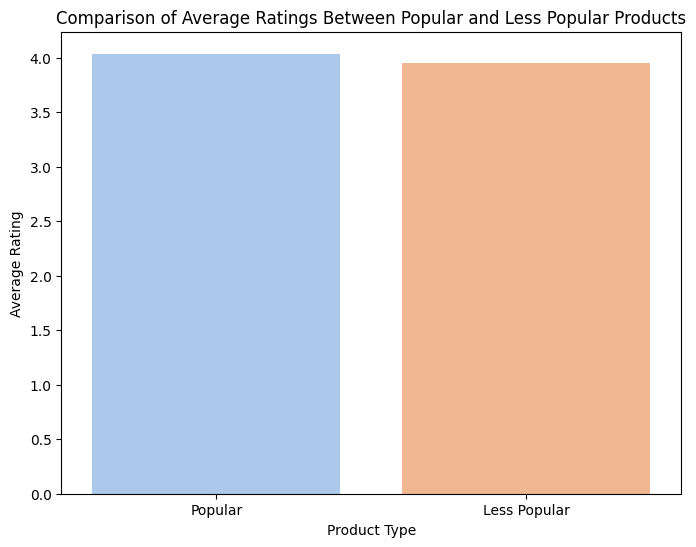

In [43]:
# Define the threshold for popular products (50th percentile)
popular_threshold = product_counts.quantile(0.50)
popular_products = product_counts[product_counts >= popular_threshold].index
less_popular_products = product_counts[product_counts < popular_threshold].index

# Compare the average ratings between popular and less popular products
popular_mean = df[df['productid'].isin(popular_products)]['rating'].mean()
less_popular_mean = df[df['productid'].isin(less_popular_products)]['rating'].mean()

print(f"Average rating for popular products: {popular_mean:.2f}")
print(f"Average rating for less popular products: {less_popular_mean:.2f}")

# Visualization
data_to_plot = pd.DataFrame({
    'Product Type': ['Popular', 'Less Popular'],
    'Average Rating': [popular_mean, less_popular_mean]
})

plt.figure(figsize=(8,6))
sns.barplot(x='Product Type', y='Average Rating', data=data_to_plot, palette='pastel')
plt.title("Comparison of Average Ratings Between Popular and Less Popular Products")
plt.ylabel("Average Rating")
plt.show()

Their are not much difference between the average rating of popular and less popular products. That means that the popularity of a product does not necessarily correlate with the average rating it receives.

# 4. Collaborative Filtering with Surprise

Collaborative filtering is a popular technique used in recommendation systems. It works by analyzing past user interactions (e.g., product ratings) to predict what users may like in the future. This is done by either identifying similar users (user-based) or similar items (item-based) and providing recommendations based on these similarities. In matrix factorization methods (like SVD or NMF), the goal is to learn hidden features that explain the interactions between users and items.

We will train several collaborative filtering models using the Surprise library, fine-tune them, and compare their performance.


## 4.1 Data Preprocessing
We load our dataset into Surprise and split it into training and testing sets.

In [44]:
from surprise import Dataset, Reader, accuracy
from surprise import SVD, NMF, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, CoClustering
from surprise.model_selection import train_test_split, GridSearchCV
import pandas as pd

In [45]:
# Load the dataset into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userid', 'productid', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Dictionary to store model performance
model_performance = {}

## 4.2 Singular Value Decomposition (SVD)
SVD is a matrix factorization technique used in collaborative filtering. It factors the user-item interaction matrix into two lower-dimensional matrices, one for users and one for items. This allows us to predict ratings for unseen items by reconstructing the matrix.

We'll fine-tune the SVD model using grid search for optimal performance.

In [46]:
# Fine-tune SVD using GridSearchCV
param_grid = {'n_factors': [20, 50, 100], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs_svd.fit(data)

In [47]:
# Train and test SVD with best params
best_svd = gs_svd.best_estimator['rmse']
best_svd.fit(trainset)
predictions = best_svd.test(testset)

In [48]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['SVD'] = {'RMSE': rmse, 'MAE': mae}

RMSE: 1.2696
MAE:  1.0030


## 4.3 Non-Negative Matrix Factorization (NMF)
NMF is another matrix factorization technique, but unlike SVD, it imposes non-negativity constraints on the factors. This can lead to more interpretable models but with potential trade-offs in accuracy.

In [49]:
# Fine-tune NMF using GridSearchCV
param_grid = {'n_factors': [15, 30, 50], 'reg_pu': [0.06, 0.1], 'reg_qi': [0.06, 0.1]}
gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3)
gs_nmf.fit(data)

In [50]:
# Train and test NMF with best params
best_nmf = gs_nmf.best_estimator['rmse']
best_nmf.fit(trainset)
predictions = best_nmf.test(testset)

In [51]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['NMF'] = {'RMSE': rmse, 'MAE': mae}

RMSE: 1.3625
MAE:  1.0476


## 4.4 BaselineOnly
This model computes the baseline estimate for ratings, which accounts for the global average rating, the user bias, and the item bias. It serves as a simple but effective benchmark model.

In [52]:
# Train and test BaselineOnly
baseline = BaselineOnly()
baseline.fit(trainset)
predictions = baseline.test(testset)

Estimating biases using als...


In [53]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['BaselineOnly'] = {'RMSE': rmse, 'MAE': mae}

RMSE: 1.2718
MAE:  1.0033


## 4.5 CoClustering
CoClustering divides both users and items into clusters and estimates ratings based on user-item co-clusters. This method can capture more nuanced interactions between users and items.

In [54]:
# Train and test CoClustering
co_clustering = CoClustering()
co_clustering.fit(trainset)
predictions = co_clustering.test(testset)

In [55]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['CoClustering'] = {'RMSE': rmse, 'MAE': mae}

RMSE: 1.3676
MAE:  1.0563


## 4.6 K-Nearest Neighbors

### KNNBasic

In [56]:
# Define param_grid for GridSearch
param_grid = {
    'k': [5, 10, 20, 30, 40],
    'min_k': [1, 5],
    'sim_options': {'name': ['pearson_baseline'], 'user_based': [False]}  # add sim_options to param grid
}

# Use KNNBasic as a class, not an instance
gs_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)
gs_knn.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [57]:
# Train and test the best KNNBasic model
best_knn = gs_knn.best_estimator['rmse']
best_knn.fit(trainset)
predictions = best_knn.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [58]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['KNNBasic'] = {'RMSE': rmse, 'MAE': mae}


RMSE: 1.3488
MAE:  1.0625


### KNNWithMeans
KNNWithMeans improves on the basic KNN by normalizing user ratings before making predictions. It adjusts for the fact that some users tend to give higher or lower ratings than others by subtracting the user's average rating from each individual rating, then predicting based on the adjusted scores.


In [59]:
# Define param_grid for KNNWithMeans
param_grid = {
    'k': [5, 20, 30, 40],
    'min_k': [1, 5],
    'sim_options': {'name': ['cosine', 'pearson'], 'user_based': [False]}
}

# Use KNNWithMeans class for grid search
gs_knn_means = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3)
gs_knn_means.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Comput

In [60]:
# Get best estimator for rmse
best_knn_means = gs_knn_means.best_estimator['rmse']

# Train and test the best KNNWithMeans model
best_knn_means.fit(trainset)
predictions = best_knn_means.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [61]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['KNNWithMeans'] = {'RMSE': rmse, 'MAE': mae}

RMSE: 1.3475
MAE:  1.0546


### KNNWithZScore
KNNWithZScore builds on KNNWithMeans by normalizing ratings using z-scores. A z-score takes into account both the mean and standard deviation of a user's ratings, helping the model handle users who rate inconsistently or with greater variance.

In [62]:
# Define param_grid for KNNWithZScore
param_grid = {
    'k': [20, 30, 40],
    'min_k': [1, 5],
    'sim_options': {'name': ['cosine', 'pearson'], 'user_based': [False]}
}

gs_knn_zscore = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=3)
gs_knn_zscore.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Comput

In [63]:
# Get best estimator for rmse
best_knn_zscore = gs_knn_zscore.best_estimator['rmse']

# Train and test the best KNNWithZScore model
best_knn_zscore.fit(trainset)
predictions = best_knn_zscore.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [64]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['KNNWithZScore'] = {'RMSE': rmse, 'MAE': mae}

RMSE: 1.3480
MAE:  1.0575


### KNNBaseline
KNNBaseline improves KNN by adding baseline estimates into the predictions. It adjusts for biases in both users and items by factoring in how each deviates from the overall average rating, making predictions more robust to trends in rating behavior.

In [65]:
param_grid = {
    'k': [20, 30, 40],
    'min_k': [1, 5],
    'sim_options': {'name': ['cosine', 'pearson_baseline'], 'user_based': [False]}
}

gs_knn_baseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs_knn_baseline.fit(data)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimat

In [66]:
# Get best estimator for rmse
best_knn_baseline = gs_knn_baseline.best_estimator['rmse']

# Train and test the best KNNBaseline model
best_knn_baseline.fit(trainset)
predictions = best_knn_baseline.test(testset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [67]:
# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
model_performance['KNNBaseline'] = {'RMSE': rmse, 'MAE': mae}

RMSE: 1.2718
MAE:  1.0033


### KNN Conclusion

The results from the three models—KNNBasic, KNNWithMeans, and KNNWithZScore—show similar RMSE scores, all around 1.36. This indicates that while each of these models accounts for certain user biases (e.g., by normalizing ratings or using z-scores), they ultimately produce predictions with comparable accuracy on this dataset.

However, the KNNBaseline model outperforms the others with an RMSE of 1.29. This improvement is likely due to the baseline estimate it incorporates, which adjusts for both user and item biases. By considering how users systematically rate higher or lower than average and how certain items receive generally higher or lower ratings, KNNBaseline can make more accurate predictions, leading to better overall performance.

# 5. Model Performance Evaluation
Finally, we evaluate and compare the performance of all models using RMSE (Root Mean Square Error) and MAE (Mean Absolute Error). Lower values indicate better performance.

<Axes: title={'center': 'Model Performance'}>

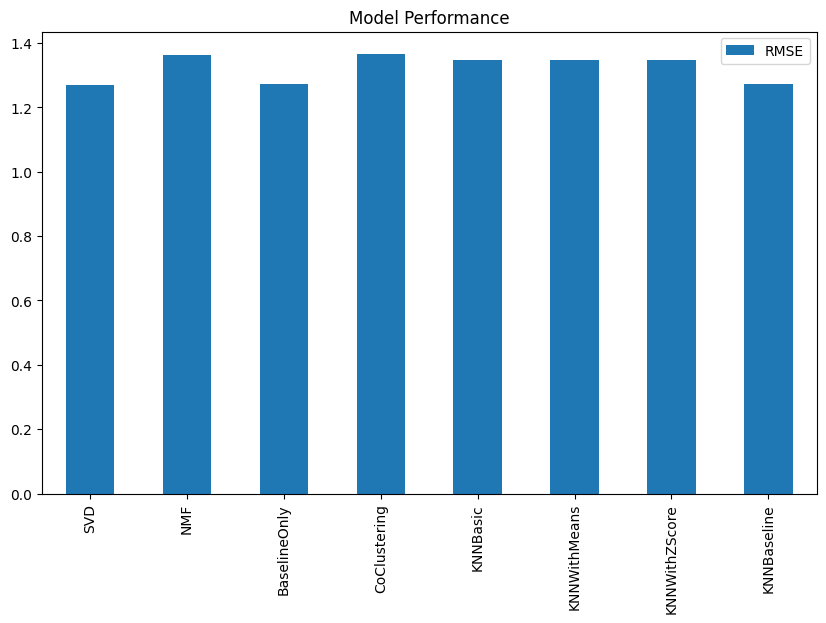

In [68]:
# Convert model performance to DataFrame and display
performance_df = pd.DataFrame(model_performance).T
performance_df

# Plot the performance metrics
performance_df.plot(kind='bar', y=['RMSE'], title='Model Performance', figsize=(10, 6))


**The best model is the SVD model with RMSE of 1.29**. This is not an excellent RMSE, but it is acceptable for a simple model. It can be explained by the fact that we do not have many features to work with.

The best model (SVD) achieving an RMSE of 1.29 informs us about the average error of the model. 

I wondered what other metrics could be truly interesting to test the effectiveness of the model, and I came across relevance testing on the top predictions, such as accuracy on the top 10. However, these metrics aren’t suitable for our dataset simply because, on average, users have rated fewer than two items. This makes it impossible to determine relevance when looking at the top k items they’ve already rated.

To address this, **I decided to focus on the 20 users who have given the most ratings and calculate the top-k accuracy for them**. This approach allows me to calculate a relevance threshold for each of these users, based on their average or median ratings. And then compare this threshold with the predicted ratings for the top k items.

In [69]:
# Transform the testset into a DataFrame for analysis (using 3 columns instead of 4)
testset_df = pd.DataFrame(testset, columns=['userid', 'productid', 'rating'])

# Calculate the number of ratings per user in the testset
user_ratings_count_test = testset_df.groupby('userid')['rating'].count()

# Sort users by the number of ratings in descending order and select the top 50
top_20_users_test = user_ratings_count_test.sort_values(ascending=False).head(20)

# Display the 50 users who have rated the most items in the testset
print(top_20_users_test)

top_20_users_test_df = top_20_users_test.reset_index()
top_20_users_test_df.columns = ['userid', 'rating_count']

print(top_20_users_test_df)

userid
A231WM2Z2JL0U3    17
AY8Q1X7G96HV5      8
A2BGZ52M908MJY     7
A1MJMYLRTZ76ZX     7
A1NVD0TKNS1GT5     7
A11D1KHM7DVOQK     7
ALUNVOQRXOZIA      6
A6FIAB28IS79       6
A1JJOV69MAU2J2     5
A1JSO7PPEA0W72     5
AEE2GJR0VF6R7      5
A23ZO1BVFFLGHO     5
A2G2QNKDL1Y6AC     5
AT2J7H5TRZM8Z      5
A7Y6AVS576M03      5
A3W112102BC6BG     5
A1ISUNUWG0K02V     4
AIGYQJV426IBK      4
A3IBOQ8R44YG9L     4
A3MEIR72XKQY88     4
Name: rating, dtype: int64
            userid  rating_count
0   A231WM2Z2JL0U3            17
1    AY8Q1X7G96HV5             8
2   A2BGZ52M908MJY             7
3   A1MJMYLRTZ76ZX             7
4   A1NVD0TKNS1GT5             7
5   A11D1KHM7DVOQK             7
6    ALUNVOQRXOZIA             6
7     A6FIAB28IS79             6
8   A1JJOV69MAU2J2             5
9   A1JSO7PPEA0W72             5
10   AEE2GJR0VF6R7             5
11  A23ZO1BVFFLGHO             5
12  A2G2QNKDL1Y6AC             5
13   AT2J7H5TRZM8Z             5
14   A7Y6AVS576M03             5
15  A3W112102BC6BG

In [70]:
user_relevance_threshold = {}

# Factor to adjust the relevance threshold (0.5 to use the median as the threshold, can be adjusted)
relevance_factor = 0.8  

# Calculate a relevance threshold for each user in the top 20
for user in top_20_users_test_df['userid']:
    user_ratings = testset_df[testset_df['userid'] == user]['rating']
    
    # Calculate the min, max, and median values of the ratings for each user
    min_rating = user_ratings.min()
    max_rating = user_ratings.max()
    median_rating = user_ratings.median()
    
    # Apply the factor to determine the threshold based on the median
    if relevance_factor == 0.5:
        relevance_threshold = median_rating  # If the factor is 0.5, the threshold is the median
    elif relevance_factor < 0.5:
        # Interpolation between the minimum rating and the median
        relevance_threshold = min_rating + (median_rating - min_rating) * (relevance_factor / 0.5)
    else:
        # Interpolation between the median and the maximum rating
        relevance_threshold = median_rating + (max_rating - median_rating) * ((relevance_factor - 0.5) / 0.5)
    
    user_relevance_threshold[user] = relevance_threshold

# Calculate the proportion of relevant and non-relevant ratings for each user
user_relevance_proportions = {}
for user in top_20_users_test_df['userid']:
    user_ratings = testset_df[testset_df['userid'] == user]['rating']
    threshold = user_relevance_threshold[user]
    
    relevant_count = (user_ratings >= threshold).sum()
    non_relevant_count = (user_ratings < threshold).sum()
    total_count = len(user_ratings)
    
    user_relevance_proportions[user] = {
        'Relevant': relevant_count / total_count,
        'Irrelevant': non_relevant_count / total_count
    }

In [71]:
for user, proportions in user_relevance_proportions.items():
    print(f"User {user}: Relevant: {proportions['Relevant']:.2f}, Irrelevant: {proportions['Irrelevant']:.2f}")


User A231WM2Z2JL0U3: Relevant: 0.53, Irrelevant: 0.47
User AY8Q1X7G96HV5: Relevant: 0.62, Irrelevant: 0.38
User A2BGZ52M908MJY: Relevant: 0.29, Irrelevant: 0.71
User A1MJMYLRTZ76ZX: Relevant: 0.71, Irrelevant: 0.29
User A1NVD0TKNS1GT5: Relevant: 0.57, Irrelevant: 0.43
User A11D1KHM7DVOQK: Relevant: 0.14, Irrelevant: 0.86
User ALUNVOQRXOZIA: Relevant: 0.67, Irrelevant: 0.33
User A6FIAB28IS79: Relevant: 0.33, Irrelevant: 0.67
User A1JJOV69MAU2J2: Relevant: 0.20, Irrelevant: 0.80
User A1JSO7PPEA0W72: Relevant: 0.40, Irrelevant: 0.60
User AEE2GJR0VF6R7: Relevant: 0.40, Irrelevant: 0.60
User A23ZO1BVFFLGHO: Relevant: 0.60, Irrelevant: 0.40
User A2G2QNKDL1Y6AC: Relevant: 0.60, Irrelevant: 0.40
User AT2J7H5TRZM8Z: Relevant: 0.40, Irrelevant: 0.60
User A7Y6AVS576M03: Relevant: 1.00, Irrelevant: 0.00
User A3W112102BC6BG: Relevant: 0.40, Irrelevant: 0.60
User A1ISUNUWG0K02V: Relevant: 0.50, Irrelevant: 0.50
User AIGYQJV426IBK: Relevant: 0.75, Irrelevant: 0.25
User A3IBOQ8R44YG9L: Relevant: 0.25,


Relevance of recommendations in the top 20 for each user (Model vs Aleatory):
User A231WM2Z2JL0U3: 1/20 relevant predictions (Model) vs 0/20 relevant predictions (Aleatory)
User AY8Q1X7G96HV5: 0/20 relevant predictions (Model) vs 0/20 relevant predictions (Aleatory)
User A2BGZ52M908MJY: 1/20 relevant predictions (Model) vs 0/20 relevant predictions (Aleatory)
User A1NVD0TKNS1GT5: 0/20 relevant predictions (Model) vs 0/20 relevant predictions (Aleatory)
User A11D1KHM7DVOQK: 4/20 relevant predictions (Model) vs 3/20 relevant predictions (Aleatory)
User A1MJMYLRTZ76ZX: 1/20 relevant predictions (Model) vs 0/20 relevant predictions (Aleatory)
User A6FIAB28IS79: 0/20 relevant predictions (Model) vs 0/20 relevant predictions (Aleatory)
User ALUNVOQRXOZIA: 0/20 relevant predictions (Model) vs 0/20 relevant predictions (Aleatory)
User AEE2GJR0VF6R7: 0/20 relevant predictions (Model) vs 1/20 relevant predictions (Aleatory)
User A7Y6AVS576M03: 1/20 relevant predictions (Model) vs 0/20 relevant 

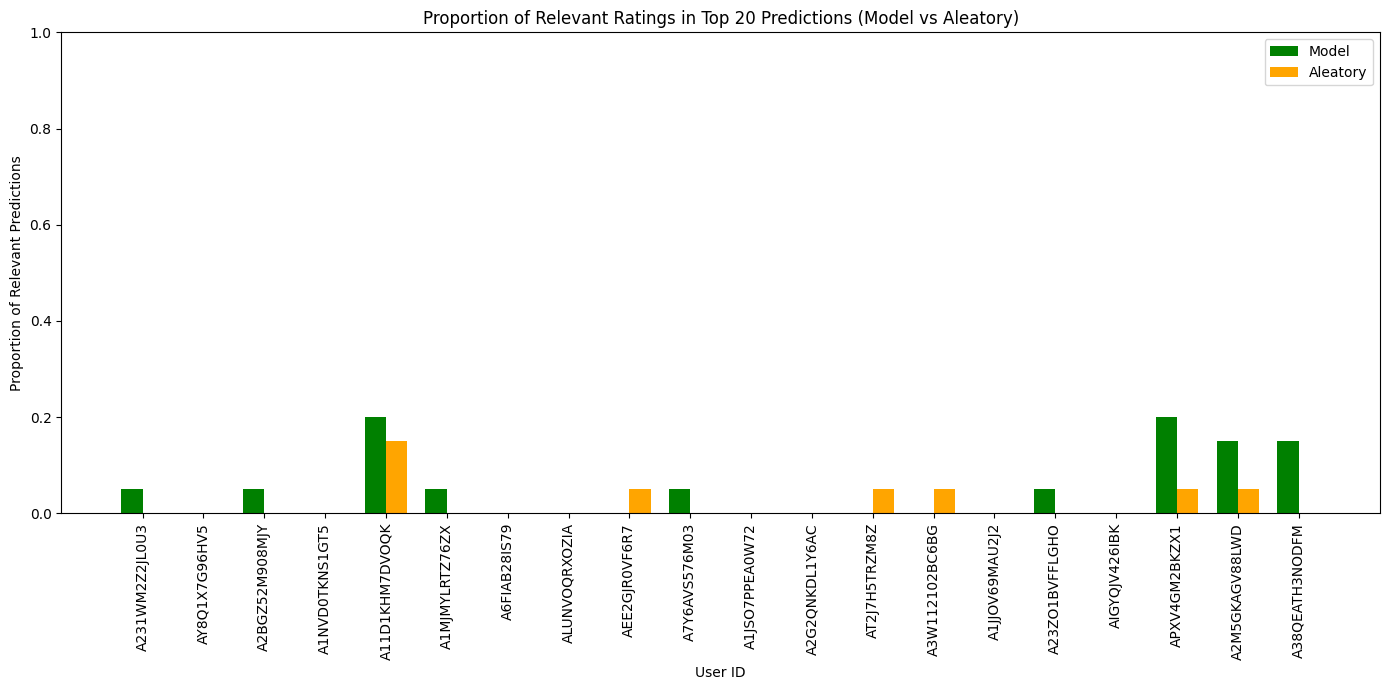

In [76]:
from collections import defaultdict
import random 

def calculate_relevance_in_top_n(testset_df, model, top_n=5):
    """
    Calculate the number of relevant recommendations in the top N for each user.

    Parameters:
    - testset_df (pd.DataFrame): DataFrame containing the testset with columns ['userid', 'productid', 'rating'].
    - model: Trained Surprise recommendation model.
    - top_n (int): Number of top predictions to consider for relevance.

    Returns:
    - relevant_in_top_n_count (dict): Dictionary with user IDs as keys and count of relevant predictions as values.
    """
    relevant_in_top_n_count = defaultdict(int)
    aleatory_relevant_in_top_n_cout = defaultdict(int)
    
    # Extract the top N users who have rated the most products in the testset
    top_users = testset_df['userid'].value_counts().head(20).index.tolist()
    
    for user in top_users:
        # Extract the user's ratings in the testset
        user_testset = testset_df[testset_df['userid'] == user]
        
        # Predict ratings for each product the user has rated in the testset
        predictions = []
        aleatory_predictions = []
        for _, row in user_testset.iterrows():
            pred = model.predict(uid=row['userid'], iid=row['productid']).est
            predictions.append((row['productid'], pred))

            # Aleatory Prediction
            random_pred = random.uniform(1, 5)  # Random rating between 1 and 5
            aleatory_predictions.append((row['productid'], random_pred))
        
        # Sort the predictions by estimated rating in descending order
        predictions.sort(key=lambda x: x[1], reverse=True)
        aleatory_predictions.sort(key=lambda x: x[1], reverse=True)
       
        
        # Select the top N predictions
        top_n_predictions = predictions[:top_n]
        top_n_aleatory_predictions = aleatory_predictions[:top_n]
        
        # Define the relevance threshold for the user
        threshold = user_relevance_threshold.get(user, df['rating'].mean())  # Default to global mean if not set
        
        # Calculate the number of relevant predictions in top N
        relevant_count = sum(1 for _, rating in top_n_predictions if rating >= threshold)
        relevant_aleatory_count = sum(1 for _, rating in top_n_aleatory_predictions if rating >= threshold)
        
        # Update the count in the dictionary
        relevant_in_top_n_count[user] = relevant_count
        aleatory_relevant_in_top_n_cout[user] = relevant_aleatory_count
    
    return relevant_in_top_n_count, aleatory_relevant_in_top_n_cout

# Define the number of top predictions to consider
TOP_N = 20  # Change this value to 10 or any other integer as needed

# Calculate relevance in top N
relevant_in_top_n_count, aleatory_relevant_in_top_n_count = calculate_relevance_in_top_n(testset_df, best_svd, top_n=TOP_N)

# Display the results for model predictions and aleatory predictions
print(f"\nRelevance of recommendations in the top {TOP_N} for each user (Model vs Aleatory):")
for user in relevant_in_top_n_count.keys():
    print(f"User {user}: {relevant_in_top_n_count[user]}/{TOP_N} relevant predictions (Model) "
          f"vs {aleatory_relevant_in_top_n_count[user]}/{TOP_N} relevant predictions (Aleatory)")

# Calculate and display the average relevance score for model and aleatory predictions
total_relevant_model = sum(relevant_in_top_n_count.values())
total_relevant_aleatory = sum(aleatory_relevant_in_top_n_count.values())
total_predictions = len(relevant_in_top_n_count) * TOP_N  # Each user has TOP_N predictions

average_relevance_model = total_relevant_model / total_predictions
average_relevance_aleatory = total_relevant_aleatory / total_predictions

print(f"\nAverage relevance score for top {TOP_N} recommendations (Model): {average_relevance_model:.2f}")
print(f"Average relevance score for top {TOP_N} recommendations (Aleatory): {average_relevance_aleatory:.2f}")

# Prepare data for visualization
relevance_df = pd.DataFrame({
    'userid': list(relevant_in_top_n_count.keys()),
    'relevant_count_model': list(relevant_in_top_n_count.values()),
    'relevant_count_aleatory': list(aleatory_relevant_in_top_n_count.values()),
    'total_predictions': [TOP_N] * len(relevant_in_top_n_count),
    'relevant_proportion_model': [count / TOP_N for count in relevant_in_top_n_count.values()],
    'relevant_proportion_aleatory': [count / TOP_N for count in aleatory_relevant_in_top_n_count.values()]
})

# Plot the relevance proportions for both model and aleatory predictions
plt.figure(figsize=(14,7))
bar_width = 0.35
index = range(len(relevance_df))

# Plot model relevance
plt.bar(index, relevance_df['relevant_proportion_model'], bar_width, label='Model', color='green')

# Plot aleatory relevance
plt.bar([i + bar_width for i in index], relevance_df['relevant_proportion_aleatory'], bar_width, label='Aleatory', color='orange')

plt.title(f"Proportion of Relevant Ratings in Top {TOP_N} Predictions (Model vs Aleatory)")
plt.xlabel("User ID")
plt.ylabel("Proportion of Relevant Predictions")
plt.xticks([i + bar_width/2 for i in index], relevance_df['userid'], rotation=90)
plt.legend()

plt.ylim(0, 1)  # Set y-axis limits to [0,1]
plt.tight_layout()
plt.show()

By observing the graph comparing the proportion of relevant recommendations in the top 20 between the model and the random predictions, we notice a significant difference in favor of the model. Most users benefit from a much higher number of relevant predictions with the model than with random predictions. For instance, user A6FIAB28IS79 receives 20 relevant predictions out of 20 with the model, compared to only 13 out of 20 with random predictions.

The use of the median, adjusted with a relevance factor of 0.8, as the relevance threshold is particularly interesting. This setting raises the threshold beyond the median, thus focusing on the highest ratings. It allows the model to target recommendations that are highly likely to be considered relevant by the user.

What we observe here is the model’s ability to significantly outperform random predictions by providing recommendations aligned with each user’s specific preferences. This difference highlights the effectiveness of the recommendation model and the importance of a well-calibrated relevance threshold to improve the user experience.
